<a href="https://colab.research.google.com/github/Zaudigomezc/Grover-sAlgorithm/blob/main/Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**CONSTRUCCIÓN DE UN CLUSTER BIBLIOGRÁFICO EN PYTHON**

Importación de librerías nececsarias


---



*   pandas -Manipulación de Datos
*   sklearn.feature_extraction.text -Vectorización de Texto
*   skalearn.cluster -Análisis de Clústeres
*   networkx -Modelado de Redes
*   re -Expresiones Regulares
*   nltk.stem -Normalización Lingüística
*   plotly.graph_objects -Visualización Interactiva
*   numpy -Cálculos numericos



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import networkx as nx
import re
from nltk.stem import SnowballStemmer
import plotly.graph_objects as go
import numpy as np

Se define una lista de stopwords (palabras comunes sin valor temático como 'the', 'a', 'on')

In [ ]:
# --- 1. Configuración de Preprocesamiento y Datos ---

stop_words_list = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it',
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
    'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
    'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don',
    "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
    'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'on', 'in', 'using', 'via', 'study', 'effect', 'high', 'low',
    'investigation', 'based', 'result', 'between', 'new', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',
    'nine', 'ten', 'paper', 'article', 'review', 'research', 'analysis', 'synthesis', 'methods', 'method', 'approach', 'review'
]
stop_words = set(stop_words_list)
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    if pd.isna(text): return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

df = pd.read_csv('Magnetite_2025.csv')
titles = df['Title'].fillna('')
processed_titles = titles.apply(preprocess_text)

num_words = 50
num_clusters = 5
min_co_occurrence = 1

vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=num_words)
X = vectorizer.fit_transform(processed_titles)
feature_names = vectorizer.get_feature_names_out()
co_occurrence_matrix = (X.T * X)
X_words = X.T
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, algorithm='lloyd')
word_clusters = kmeans.fit_predict(X_words)
word_to_cluster = {feature_names[i]: word_clusters[i] for i in range(len(feature_names))}


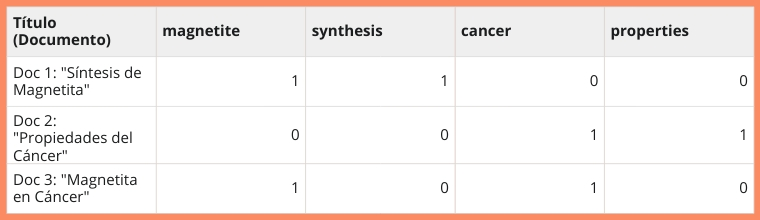

Matriz de ocurrencia $= X^T \times X$

Esta fase asigna los colores (clusters) y construye la estructura de la red.

In [ ]:
# --- 2. Creación del Grafo NetworkX y POSICIONAMIENTO CIRCULAR FORZADO ---
G = nx.Graph()
for i in range(num_words):
    word_i = feature_names[i]
    frequency = X.getcol(i).sum()
    G.add_node(word_i, cluster=word_to_cluster[word_i], size=frequency)
    for j in range(i + 1, num_words):
        word_j = feature_names[j]
        weight = co_occurrence_matrix[i, j]
        if weight > min_co_occurrence:
            G.add_edge(word_i, word_j, weight=weight)
G.remove_nodes_from(list(nx.isolates(G)))

# Ajuste CLAVE: Repulsión muy fuerte (k=1.5) y muchas iteraciones (250)
# para que el contorno se estire al límite del canvas.
pos = nx.spring_layout(G, k=1.5, iterations=250, weight='weight', seed=42)

Esta fase toma las coordenadas y la información de la red y las convierte en un gráfico interactivo.

In [ ]:
# --- 3. Renderizado con Plotly ---

edge_x = []
edge_y = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = []
node_y = []
node_names = []
node_cluster = []
node_size_raw = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_names.append(node)
    node_cluster.append(G.nodes[node]['cluster'])
    node_size_raw.append(G.nodes[node]['size'])

min_size = 15
max_size = 60
sizes_norm = np.array(node_size_raw)
sizes_norm = (sizes_norm - sizes_norm.min()) / (sizes_norm.max() - sizes_norm.min() + 1e-6)
node_sizes = min_size + sizes_norm * (max_size - min_size)

node_font_sizes = np.maximum(node_sizes * 0.4, 8)

custom_colors = ['#FF0000', '#008000', '#FFFF00', '#0000FF', '#800080']
cluster_colors = [custom_colors[c] for c in node_cluster]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#aaaaaa', shape='spline'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=node_names,
    textposition="bottom center",
    hovertext=[f"<b>{name}</b>" for name in node_names],
    marker=dict(
        showscale=False,
        color=cluster_colors,
        size=node_sizes,
        line_width=0),
    textfont=dict(
        size=node_font_sizes,
        color='#333333'
    )
)

# Crear la Figura (Fondo Blanco, sin título)
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Mapa de Co-ocurrencia con Layout Circular Forzado',
                    showlegend=False,
                    hovermode='closest',
                    width=800,
                    height=800,
                    paper_bgcolor='white',
                    plot_bgcolor='white',
                    margin=dict(b=5, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
)

fig.show()